# Lammps Obstacle
## TSCM Course
by Alexey Legoshin, 10.09.21

 
  
  
# Virtual Jupyterlab Notebook
1. This starts sbatch.sh script for modelling

In [29]:
from subprocess import run

run(["sbatch", "../sbatch.sh"], cwd="workdir")

Submitted batch job 1859720


CompletedProcess(args=['sbatch', '../sbatch.sh'], returncode=0)

2. sbatch.sh starts awk.sh, which analyses log files to read pressure for every radius in every moment of time in model. Then analysing data to write AVERAGE ( $\sum$ Pressure / time ) pressure with dependency of radius in radius.csv. Also it sends notification in Telegram about end of calculations.

3. cron.sh is a crontab script which sends info about actual process. Also it starts gnuplot.sh -- when sbatch.sh is about work ending -- to send a notifiction in Telegram with average pressure from radius plot. We can't use "gnuplot gnuplot.sh" in sbatch.sh script because in this way we are often working on some far node, where gnuplot is not available. Crontab though is working on the first node, where gnuplot is active.

4. That's about drawing graphics in Plotly -- reading from radius.csv, like in the previous step with gnuplot.


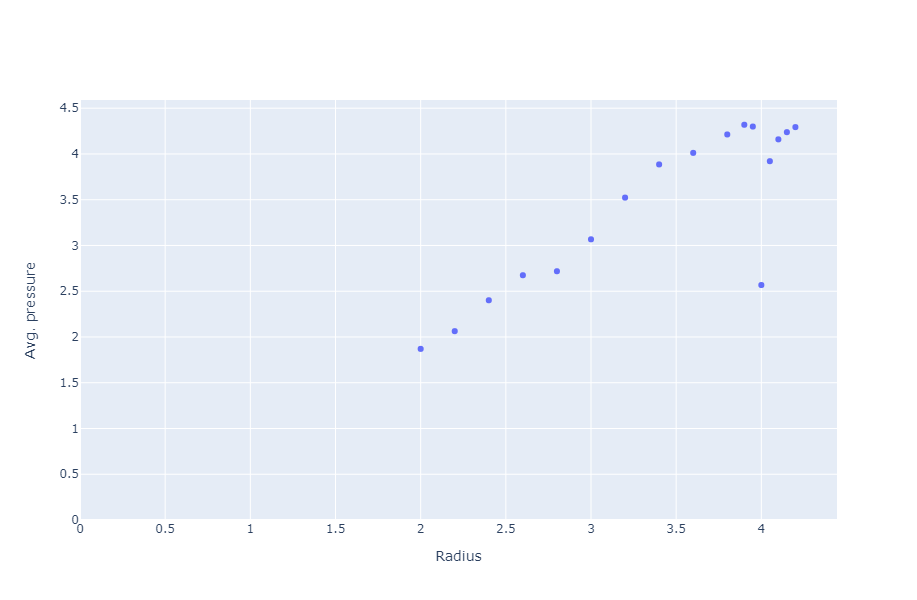

In [ ]:
import numpy as np
import plotly.graph_objects as go

graphdata = np.genfromtxt("workdir/radius.csv", delimiter=' ' , skip_header=1)
fig = go.Figure(go.Scatter(x=graphdata[:,0], y=graphdata[:,1], mode='markers'), layout={'xaxis':{'title':'Radius','rangemode':'tozero'}, 'yaxis':{'title':'Avg. pressure','rangemode':'tozero'}})
fig.layout.width = 1000
fig.layout.height = 600
fig.show()

5. Working with dump files. Using ovito to read lammps dump files -- read in ovito documentation :)
Globally using pickle and multiprocessing to read dump.obstacle faster -- for EVERY radius in one time.
Also written some kind of caching script -- can be useful in situations, when you accidentally closed jupiterlab -- data will be saved in data.pickle and can be used after loading as well. In way if you are restarting modelling data.pickle will be rewrited being deleted by sbatch.sh.

In [ ]:
import ovito # opengl warning is ok because we are running headless
import ovito.io as io

import numpy as np
import multiprocessing as mp
import pickle

usecache = False
radii = [2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6, 3.8, 3.95, 4.0, 4.05, 4.1, 4.15, 4.2]

if usecache:
    try:
        with open("workdir/data.pickle", 'rb') as file:
            data = pickle.load(file)
        print("Data loaded from cache")

    except FileNotFoundError:
        print("Cached file not found")
        usecache = False

if not usecache:
    def read_file(filename):
        src = ovito.io.import_file(filename).source
        return np.array([np.array(src.compute(i).particles.positions[...]) for i in range(src.num_frames)])

    with mp.Pool(4) as p:
        data = p.map(read_file, ["workdir/dir_rad/rad_{:.2f}/dump.obstacle".format(r) for r in radii])
    
    with open("workdir/data.pickle", 'wb') as file:
        pickle.dump(data, file)

    print("Data loaded and dumped")

print("Data shape: ")
print([d.shape for d in data])

Data loaded and dumped
Data shape: 
[(751, 791, 3), (751, 784, 3), (751, 780, 3), (751, 776, 3), (751, 748, 3), (751, 741, 3), (751, 728, 3), (751, 724, 3), (751, 707, 3), (751, 681, 3), (751, 678, 3), (751, 668, 3), (751, 664, 3), (751, 661, 3), (751, 661, 3), (751, 661, 3)]


6. nglview visualisation using data from previous step. Changing "radiusindex" value you can see visualisation for different radiuses.

In [51]:
import nglview as ngl
from ase import Atoms
from ase.visualize import view

radiusindex = 10

images = []
for pos in data[radiusindex]:
    images.append(Atoms(positions=pos))

view(images, viewer='ngl')

7. Ovito visualisation. Like in previous step changing "radiusindex" value you can receive .gif file visualisation for different radiuses.

In [46]:
import math
import numpy as np

import ovito.io as io
import ovito.vis as vis
import ovito.modifiers as md

radiusindex = 5

pipeline = io.import_file("workdir/dir_rad/rad_{:.2f}/dump.obstacle".format(radii[radiusindex]))
pipeline.add_to_scene()
data=pipeline.compute()

wall=data.cell[0][0]

vp = vis.Viewport()
vp.type = vis.Viewport.Type.Perspective

# Создаем функцию, которая бы по номеру шага выводила бы
# координаты камеры и ее направление
# В окне программы Ovito можно узнать координаты и направление камеры,
# если нажать на настройки отображения.
def get_pos_dir(frame):
    center=np.array([wall/2, wall/2, wall/2])
    radius=wall*4/3*(100-frame)/100
    hight=[0,0,wall*3/4]
    phi = frame/100*2*np.pi
    direction=np.array([np.cos(phi), np.sin(phi),0])
    position = center + direction*radius+hight
    #direction = [-1,0,-1]
    #position = [34.6, 5.2, 34.6]
    return tuple(position), tuple( (center - position) )
pos, direction = get_pos_dir(0)

vp.camera_pos = pos
vp.camera_dir = direction
vp.fov = math.radians(60.0)

# Создаем функцию, которая будет вызываться на каждом шаге
# создания видео и будет вращать нашу камеру
def render_view(args):
    global wall
    frame=args.frame
    logging.info("frame: {:d}".format(args.frame))
    pos, direction = get_pos_dir(frame)
    args.viewport.camera_pos = pos
    args.viewport.camera_dir = direction
    args.viewport.fov = math.radians(60.0)
    
vp.overlays.append(vis.PythonViewportOverlay(function = render_view))

vp.render_anim(size=(800,400), filename="workdir/animation_{:.2f}.gif".format(radii[radiusindex]),
renderer=vis.TachyonRenderer(), range=(0,101))

Output #0, gif, to 'workdir/animation_3.00.gif':
  Metadata:
    encoder         : Lavf58.45.100
    Stream #0:0: Video: gif, rgb8, 800x400, q=2-31, 10 fps, 100 tbn
[gif @ 0x55a6dc771800] Ignoring attempt to flush encoder that doesn't support it


## And after that my conda has somehow crashed :)